<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Settings</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Time-dep-functions" data-toc-modified-id="Time-dep-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time-dep functions</a></span></li><li><span><a href="#Test-vacc-strategy" data-toc-modified-id="Test-vacc-strategy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test vacc strategy</a></span></li><li><span><a href="#Test-spatial-model" data-toc-modified-id="Test-spatial-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test spatial model</a></span></li><li><span><a href="#Scenarios" data-toc-modified-id="Scenarios-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scenarios</a></span><ul class="toc-item"><li><span><a href="#Run-and-save-all-scenarios" data-toc-modified-id="Run-and-save-all-scenarios-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Run and save all scenarios</a></span></li><li><span><a href="#Scenarios-S1-(current-behaviour)" data-toc-modified-id="Scenarios-S1-(current-behaviour)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Scenarios S1 (current behaviour)</a></span><ul class="toc-item"><li><span><a href="#S1a---K-=-1.3" data-toc-modified-id="S1a---K-=-1.3-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>S1a - K = 1.3</a></span></li><li><span><a href="#S1b---K-=-1.5" data-toc-modified-id="S1b---K-=-1.5-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>S1b - K = 1.5</a></span></li><li><span><a href="#S1c---K-=-1.7" data-toc-modified-id="S1c---K-=-1.7-6.2.3"><span class="toc-item-num">6.2.3&nbsp;&nbsp;</span>S1c - K = 1.7</a></span></li></ul></li><li><span><a href="#Scenarios-S2-(september-behaviour-March-1)" data-toc-modified-id="Scenarios-S2-(september-behaviour-March-1)-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Scenarios S2 (september behaviour March 1)</a></span><ul class="toc-item"><li><span><a href="#S2a---K-=-1.3" data-toc-modified-id="S2a---K-=-1.3-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>S2a - K = 1.3</a></span></li><li><span><a href="#S2b---K-=-1.5" data-toc-modified-id="S2b---K-=-1.5-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>S2b - K = 1.5</a></span></li><li><span><a href="#S2c---K-=-1.7" data-toc-modified-id="S2c---K-=-1.7-6.3.3"><span class="toc-item-num">6.3.3&nbsp;&nbsp;</span>S2c - K = 1.7</a></span></li></ul></li><li><span><a href="#Scenario-S3-(September-behaviour-April-1)" data-toc-modified-id="Scenario-S3-(September-behaviour-April-1)-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Scenario S3 (September behaviour April 1)</a></span><ul class="toc-item"><li><span><a href="#S3a---K-=-1.3" data-toc-modified-id="S3a---K-=-1.3-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>S3a - K = 1.3</a></span></li><li><span><a href="#S3b---K-=-1.5" data-toc-modified-id="S3b---K-=-1.5-6.4.2"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>S3b - K = 1.5</a></span></li><li><span><a href="#S3c---K-=-1.7" data-toc-modified-id="S3c---K-=-1.7-6.4.3"><span class="toc-item-num">6.4.3&nbsp;&nbsp;</span>S3c - K = 1.7</a></span></li></ul></li><li><span><a href="#Scenario-S4-(September-behaviour-April-1)" data-toc-modified-id="Scenario-S4-(September-behaviour-April-1)-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Scenario S4 (September behaviour April 1)</a></span><ul class="toc-item"><li><span><a href="#S4a---K-=-1.3" data-toc-modified-id="S4a---K-=-1.3-6.5.1"><span class="toc-item-num">6.5.1&nbsp;&nbsp;</span>S4a - K = 1.3</a></span></li><li><span><a href="#S4b---K-=-1.5" data-toc-modified-id="S4b---K-=-1.5-6.5.2"><span class="toc-item-num">6.5.2&nbsp;&nbsp;</span>S4b - K = 1.5</a></span></li><li><span><a href="#S4c---K-=-1.7" data-toc-modified-id="S4c---K-=-1.7-6.5.3"><span class="toc-item-num">6.5.3&nbsp;&nbsp;</span>S4c - K = 1.7</a></span></li></ul></li><li><span><a href="#Scenarios-SNV1-(vaccination-effect)" data-toc-modified-id="Scenarios-SNV1-(vaccination-effect)-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Scenarios SNV1 (vaccination effect)</a></span><ul class="toc-item"><li><span><a href="#S3a-(S2b-without-vaccination)" data-toc-modified-id="S3a-(S2b-without-vaccination)-6.6.1"><span class="toc-item-num">6.6.1&nbsp;&nbsp;</span>S3a (S2b without vaccination)</a></span></li><li><span><a href="#S4a-(S1b-without-vaccination)" data-toc-modified-id="S4a-(S1b-without-vaccination)-6.6.2"><span class="toc-item-num">6.6.2&nbsp;&nbsp;</span>S4a (S1b without vaccination)</a></span></li></ul></li></ul></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualise</a></span><ul class="toc-item"><li><span><a href="#S1-and-S2" data-toc-modified-id="S1-and-S2-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>S1 and S2</a></span></li><li><span><a href="#Vaccination-effect" data-toc-modified-id="Vaccination-effect-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Vaccination effect</a></span></li></ul></li><li><span><a href="#Alternative-scenarios-A1" data-toc-modified-id="Alternative-scenarios-A1-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Alternative scenarios A1</a></span><ul class="toc-item"><li><span><a href="#A1a---vacc---old-strain" data-toc-modified-id="A1a---vacc---old-strain-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>A1a - vacc - old strain</a></span></li><li><span><a href="#A1b---no-vacc---new-strain" data-toc-modified-id="A1b---no-vacc---new-strain-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>A1b - no vacc - new strain</a></span></li><li><span><a href="#A1c---vaccination---old-strain" data-toc-modified-id="A1c---vaccination---old-strain-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>A1c - vaccination - old strain</a></span></li><li><span><a href="#A1d---vaccination---new-strain" data-toc-modified-id="A1d---vaccination---new-strain-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>A1d - vaccination - new strain</a></span></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Visualise</a></span></li></ul></li><li><span><a href="#Alternative-scenarios-A2" data-toc-modified-id="Alternative-scenarios-A2-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Alternative scenarios A2</a></span><ul class="toc-item"><li><span><a href="#A2a---no-vacc---old-strain" data-toc-modified-id="A2a---no-vacc---old-strain-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>A2a - no vacc - old strain</a></span></li><li><span><a href="#A2b---no-vacc---new-strain" data-toc-modified-id="A2b---no-vacc---new-strain-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>A2b - no vacc - new strain</a></span></li><li><span><a href="#A2c---vaccination---old-strain" data-toc-modified-id="A2c---vaccination---old-strain-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>A2c - vaccination - old strain</a></span></li><li><span><a href="#A2d---vaccination---new-strain" data-toc-modified-id="A2d---vaccination---new-strain-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>A2d - vaccination - new strain</a></span></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-9.5"><span class="toc-item-num">9.5&nbsp;&nbsp;</span>Visualise</a></span></li></ul></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Save data</a></span></li><li><span><a href="#Plot-saved-data" data-toc-modified-id="Plot-saved-data-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Plot saved data</a></span></li></ul></div>


*Authored by J. Vergeynst*

Copyright (c) 2021 by J. Vergeynst, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random
from math import floor

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot

plt.rcParams.update({'font.size': 12, 'axes.grid':True, 'grid.linewidth':0.3})
pd.plotting.register_matplotlib_converters()

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [60]:
plt.rcParams.update({
    "lines.linewidth" : 3,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "ytick.major.left": True,
    "axes.grid": True
})

# Data, policy and model initialization

## Load contact data

In [3]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [4]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

## Load publically available data from Sciensano

In [5]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano['D_cum'] = df_sciensano.D_tot.cumsum()

In [6]:
df_google = mobility.get_google_mobility_data(update=False, plot=False)

## Load posterior parameter distributions of calibrated parameters

In [7]:
# Load samples dictionaries
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_4_prev_full_2021-01-30_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states_sept = json.load(fp) 

In [ ]:
# fig,ax = plt.subplots()
# pd.Series(samples_dict['beta']).hist()
# pd.Series(samples_dict['tau']).hist()

## Settings

In [8]:
UL = 0.975
LL = 0.025

In [9]:
start_calibration = '2021-01-01'
end_sim = '2021-09-01'

Alle vaccins twee dosissen nodig (Pfizer, Moderna, AstraZeneca, Curevac) behalve Johnson&Johnson (pas vanaf mei)

In [10]:
# doses per day (Regeringscommissariaat Corona, published by De Tijd)
d = {}
d['jan'] = 31765
d['feb'] = 45897
d['mar-apr'] = 128499
d['may-aug'] = 78358

# proportion of age group living in nursing homes
# for simplicity we will use the data for respectively age groups 60+, 70+ and 80+
NH = {}
NH['65+'] = 0.007
NH['75+'] = (0.05+0.029)/2
NH['85+'] = (0.137+0.267)/2


# Functions

In [11]:
def vacc_strategy(t, param, d, NH, initN):
    """
    time-dependent function for vaccination strategy
    
    d : dictionary
        daily number of doses for that month
    NH : dictionary
        proportion of residents in nursing homes per age group
    initN : 2D array
        if needed, add a dimension with initN[np.newaxis]
    
    """
    
    if len(initN.shape) == 1:
         raise ValueError(
                "initN should have 2 dimensions"
            )    
    N_vacc = np.zeros(initN.shape)
    delay = pd.Timedelta('30D')
    
    t1 = pd.Timestamp('2021-01-01') + delay
    t2 = pd.Timestamp('2021-02-01') + delay
    t3 = pd.Timestamp('2021-03-01') + delay
    t4 = pd.Timestamp('2021-05-01') + delay
    
    if t < t1:
        N_vacc = np.zeros(initN.shape)
    
    elif t1 <= t < t2: # January : nursing homes + part of care personnel
        # daily vaccinated persons on immunity date = daily dose on vaccination date / 2
        daily_85 = (NH['85+']*initN[:,[8]])/31
        daily_75 = (NH['75+']*initN[:,[7]])/31
        daily_65 = (NH['65+']*initN[:,[6]])/31
        care_personnel_daily_jan = d['jan']/2-daily_85-daily_75-daily_65
        N_vacc[:,[8]] = daily_85
        N_vacc[:,[7]] = daily_75
        N_vacc[:,[6]] = daily_65
        N_vacc[:,[5,4,3,2]] = care_personnel_daily_jan/4
        
    elif t2 <= t < t3: # February : care personnel
        N_vacc[:,[5,4,3,2]] = d['feb']/2/4
        
    elif t3 <= t < t4: # March-April : 65+ and risico patients
        plus_65_left_daily = ((1-NH['85+'])*initN[:,[8]] + (1-NH['75+'])*initN[:,[7]] + (1-NH['65+'])*initN[:,[6]])/60
        rest_daily = d['mar-apr']/2 - plus_65_left_daily
        N_vacc[:,[8,7,6]] = plus_65_left_daily/3
        N_vacc[:,[5,4,3,2]] = rest_daily/4
    
    else: # May-August : all 18+
        N_vacc[:,[5,4,3,2]] = d['may-aug']/2/4
        
    return N_vacc.squeeze()
    
    

In [12]:
 def plot_band_saved_data(ax, df, mean_col, LL_col, UL_col, color, label):
    ax.fill_between(df['time'],df[LL_col], df[UL_col],alpha=0.30, facecolor = color)
    ax.plot(df['time'], df[mean_col], color=color, label=label, lw=2)
    return

In [13]:
def plot_band_age(ax, y_model, age_group, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sel(Nc=age_group), 
                    y_model[var].quantile(UL,dim="draws").sel(Nc=age_group),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].mean(dim="draws").sel(Nc=age_group), color=color, label=label, lw=2)
    return

In [14]:
def check_overtake_duration(sim, dims):
    """
    sim : data array resulting from simulation
    dims : list of dimensions over which to average
    
    Returns
    -------
    N_days : number of days before new strain takes over (99%)
    """
    end = sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)<0.99]['time'][-1].values
    start = sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)<0.99]['time'][0].values
    
    N_days = (pd.to_datetime(end)-pd.to_datetime(start))/pd.Timedelta('1D')
    
    return N_days

In [15]:
def get_date_of_exceeding_alpha(sim, dims, alpha_limit):
    """
    sim : data array resulting from simulation
    dims : list of dimensions over which to average
    """
    return pd.Timestamp(sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)>alpha_limit]['time'][0].values)

In [16]:
def sample_from_binomial(sim_result, variable, n_draws_per_sample, n_samples,
                         Y0_new=None):
                         #Y0_mean=[], Y0_median=[], Y0_LL=[], Y0_UL=[]):
    """
    Function to sample from binomial, and add the result to an existing list (if given)
    """
    
    
    Y = sim_result[variable].sum(dim="Nc").values
    # Initialize vectors
    Y_new = np.zeros((Y.shape[1],n_draws_per_sample*n_samples))
    # Loop over dimension draws
    for n in range(Y.shape[0]):
        binomial_draw = np.random.poisson( np.expand_dims(Y[n,:],axis=1),size = (Y.shape[1],n_draws_per_sample))
        Y_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    # Compute mean and median
    if Y0_new is None:
        Y_new = Y_new
    else:
        Y_new = np.append(Y0_new, Y_new, axis=0)

    return Y_new
    
    

In [17]:
def plot_band_binom(ax, time, Y_binom, color, label, axis=1):
    ax.fill_between(time, np.quantile(Y_binom, q = LL, axis = axis), 
                    np.quantile(Y_binom, q = UL, axis = axis),alpha=0.30, facecolor = color)
    ax.plot(time,np.mean(Y_binom,axis=axis), color=color, label=label, lw=2, linestyle='--')
    return

In [111]:
def draw_fcn(param_dict,samples_dict,to_sample):
    # Sample
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['l'] = samples_dict['l'][idx] 
    param_dict['tau'] = samples_dict['tau'][idx]    
    param_dict['prev_home'] = samples_dict['prev_home'][idx] 
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]    
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx] 
    #param_dict['K'] = np.random.uniform(infectivity_gain_lower,infectivity_gain_upper)
    return param_dict

In [19]:
def plot_band(ax, y_model, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),
                    y_model[var].sum(dim="Nc").quantile(LL,dim="draws"), 
                    y_model[var].sum(dim="Nc").quantile(UL,dim="draws"),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].sum(dim="Nc").mean(dim="draws"), color=color, label=label, lw=2)
    return

# Time-dep functions

In [20]:
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)

In [164]:
def report7_policy_function(t, param, l , tau, prev_home, prev_schools, prev_work, prev_rest,scenario='1a'):
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define key policy dates
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2020-12-24')
    t10 = pd.Timestamp('2020-12-26')
    t11 = pd.Timestamp('2020-12-31')
    t12 = pd.Timestamp('2021-01-01')
    t13 = pd.Timestamp('2020-01-04') # Opening of schools
    #t14 = pd.Timestamp('2021-01-18') # start of alternative policies
    t15 = pd.Timestamp('2021-02-15') # Start of Krokus break
    t16 = pd.Timestamp('2021-02-21') # End of Krokus break
    t17 = pd.Timestamp('2021-03-01') # release to SB March 1
    t18 = pd.Timestamp('2021-04-01') # release to SB April 1
    t19 = pd.Timestamp('2021-05-01') # release to SB May 1

    # Average out september mobility

    if t5 < t <= t6 + tau_days:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t8 < t <= t9:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t9 < t <= t13:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                        school=0)
    elif t13 < t <= t15:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                        school=0.6)
    elif t15 < t <= t16:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                        school=0)    
    else:
        # Scenario 1: Current contact behaviour + schools open on January 18th
        if scenario == '1':
                                
            if t > t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
                    
        # Scenario 2: increases in work or leisure mobility on March 1
        elif scenario == '2':
            if t16 < t <= t17:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)  
            elif t > t17:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
        # Scenario 3: increases in work or leisure mobility on April 1
        elif scenario == '3':
            if t16 < t <= t18:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)  
            elif t > t18:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
        # Scenario 4: increases in work or leisure mobility on May 1
        elif scenario == '4':
            if t16 < t <= t19:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)  
            elif t > t19:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
        else:
            raise Exception ('scenario '+scenario+' non-existing')

In [22]:
def vaccin_model(initial_states, scenario, effectivity=None, injection_day=0, injection_ratio=0,
                 Nc_fun=None, N_vacc_fun=vacc_strategy, levels=levels):
    """
    Function to initialize the model given a certain vaccination strategy
    """
    params = model_parameters.get_COVID19_SEIRD_parameters()
    params.update({
            'l' : 5,
            'tau' : 5,
            'prev_home': 0.5,
            'prev_schools': 0.5,
            'prev_work': 0.5,
            'prev_rest': 0.5,
            'scenario': scenario,
            'injection_day' : injection_day,
            'injection_ratio' : injection_ratio
                  })
    
    tdp = {}
    
    if Nc_fun is not None:
        tdp.update({'Nc': Nc_fun})
    if N_vacc_fun is not None:
        tdp.update({'N_vacc':N_vacc_fun})
        params.update({
            'd' : d,
            'NH' : NH,
            'e' : np.array([effectivity]*levels),
            'initN' : initN[np.newaxis]
        })
    return models.COVID19_SEIRD(initial_states, params, time_dependent_parameters=tdp)

# Test vacc strategy

In [ ]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN, 'E': np.ones(levels), 'I': np.ones(levels), 'alpha':np.zeros(9)}

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters()
dummy_model_no_vacc = models.COVID19_SEIRD(initial_states, params)
sim_dummy_model_no_vacc = dummy_model_no_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
               'initN' : initN[np.newaxis]
              })
dummy_model_vacc = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
injection_day = (pd.Timestamp('2021-01-01') - pd.Timestamp(start_calibration))/pd.Timedelta('1D')
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
               'K' : 1.6,
               'initN' : initN[np.newaxis],
               'injection_day': injection_day,
               'injection_ratio':0.1,
              })

dummy_model_vacc_UK = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc_UK = dummy_model_vacc_UK.sim(time=end_sim, start_date=start_calibration)

In [ ]:
timerange = pd.date_range(start_calibration,'2021-09-01')
test_dict = {}
for t in timerange:
    test_dict[t] = np.sum(vacc_strategy(t=t, param=None, d=d, NH=NH, initN=initN[np.newaxis]))
test_df = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
test_df.columns = ['date','N_vacc']
test_df['N_cum'] = test_df.N_vacc.cumsum()

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot('date', 'N_vacc', data=test_df, c='green', label='time-dep function')
ax.plot(sim_dummy_model_vacc['time'], sim_dummy_model_vacc['V_new'].sum(dim='Nc'), c='blue', linestyle='--', label='model')
ax.legend()
ax.set_ylabel('Daily vaccination number')

In [ ]:
fig,ax = plt.subplots(figsize=(11,5))
ax.plot('date', 'N_cum', data=test_df, c='black')
ax2 = ax.twinx()
ax2.plot('date', 'N_vacc', data=test_df, c='gray', linestyle='--')
ax.set_ylabel('Total number of people vaccinated')
ax2.set_ylabel('Number of people vaccinated daily')
ax.grid(False)
ax2.grid(False)
ax.set_xlabel('Time')
ax.set_ylim(0,)
ax2.set_ylim(0,)
ax2.set_axis_on()
yticks = [2,4,6,8]
ax.set_yticks([0]+[i*10**6 for i in yticks])
ax.set_yticklabels(['0']+[str(i)+'*10$^6$' for i in yticks])
yticks2 = [2,4,6]
ax2.set_yticks([0]+[i*10**4 for i in yticks2])
ax2.set_yticklabels(['0']+[str(i)+'*10$^4$' for i in yticks2])
fig.savefig('../../results/predictions/national/restore_v7.0/vacc_strategy', dpi=400)

In [ ]:
N = d['jan']/2*31+d['feb']/2*28+d['mar-apr']/2*(31+30)+d['may-aug']/2*(31+30)
print('Approximate total number of vaccinations by august 1: {}'.format(N))
#pd.to_datetime(end_sim) - pd.to_datetime(start_calibration)
V_pool_aug = sim_dummy_model_vacc['V'].sum(dim='Nc').values[-1]
print('Number of persons in vaccinated pool by end of simulation: {}'.format(V_pool_aug))
V_new_sum = sim_dummy_model_vacc['V_new'].sum(dim='Nc').sum(dim='time').values
print('Total number of people vaccinated by end of simulation: {}'.format(V_new_sum))

In [ ]:
population_status(sim_dummy_model_no_vacc)

In [ ]:
population_status(sim_dummy_model_vacc)

In [ ]:
population_status(sim_dummy_model_vacc_UK)

In [ ]:
population_status(sim_dummy_model_vacc_UK)

In [ ]:
# check evolutie van alpha
fig,ax = plt.subplots()
sim_dummy_model_vacc_UK['alpha'].mean(dim='Nc').plot(ax=ax)

In [ ]:
N_days = check_overtake_duration(sim_dummy_model_vacc_UK, dims='Nc')
N_days

duurt altijd ong. 100 dagen..., onafhankelijk van hoeveel je initialiseert. Ws omdat in deze test het virus nog niet verspreid is (en iedereen susceptible), dus de verspreiding wordt direct volledig overgenomen door besmettelijke variant.

# Test spatial model

In [201]:
geo_unit = 'prov'
initN_spatial, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=geo_unit)
shape = initN_spatial.shape

In [202]:
# divide daily vaccinations over spatial units according to population fraction in unit
fraction_per_arr = initN_spatial.sum(axis=1)/initN_spatial.sum().sum()
d_spatial = {key:el*fraction_per_arr[:,np.newaxis] for key,el in d.items()}

In [203]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN_spatial, 'E': np.ones(shape), 'I': np.ones(shape), 'alpha':np.zeros(shape)}

In [204]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=geo_unit)
dummy_spatial_model = models.COVID19_SEIRD_spatial(initial_states, params, spatial=geo_unit)
sim_dummy_spatial_model = dummy_spatial_model.sim(time=end_sim, start_date=start_calibration)

In [205]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=geo_unit)
params.update({'d' : d_spatial,
               'NH' : NH,
               'e' : np.ones(levels)*0.9,
               'initN' : initN_spatial
              })
dummy_spatial_model_vacc = models.COVID19_SEIRD_spatial(initial_states, params, spatial=geo_unit, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_spatial_model_vacc = dummy_spatial_model_vacc.sim(time=end_sim, start_date=start_calibration)

/Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/models/models.py:422: RuntimeWarning: overflow encountered in exp
  f = 1 + (1 - np.exp(-xi * rho))
/Applications/miniconda3/envs/work/lib/python3.8/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/models/models.py:427: RuntimeWarning: overflow encountered in matmul
  zi = Ti / np.matmul(np.transpose(T_eff),f)


<IPython.core.display.Javascript object>


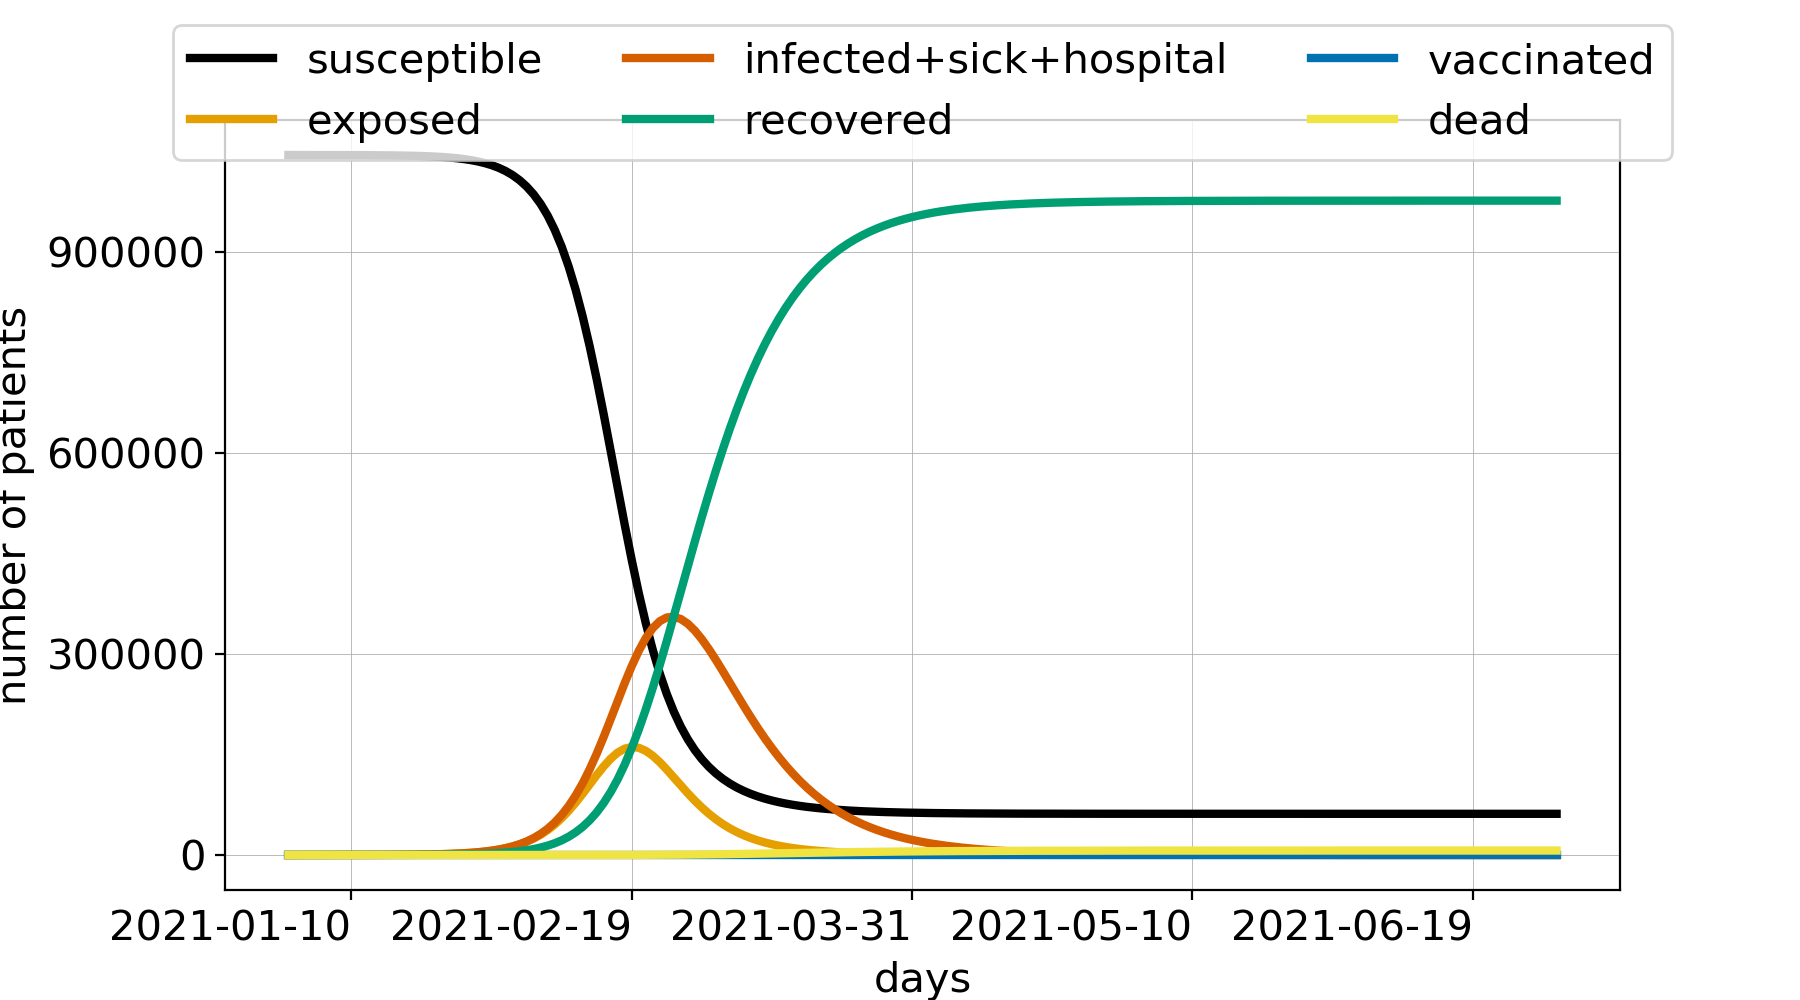

In [207]:
population_status(sim_dummy_spatial_model.mean(dim='place'))

In [ ]:
sim_dummy_spatial_model_vacc.mean(dim='place')

<IPython.core.display.Javascript object>


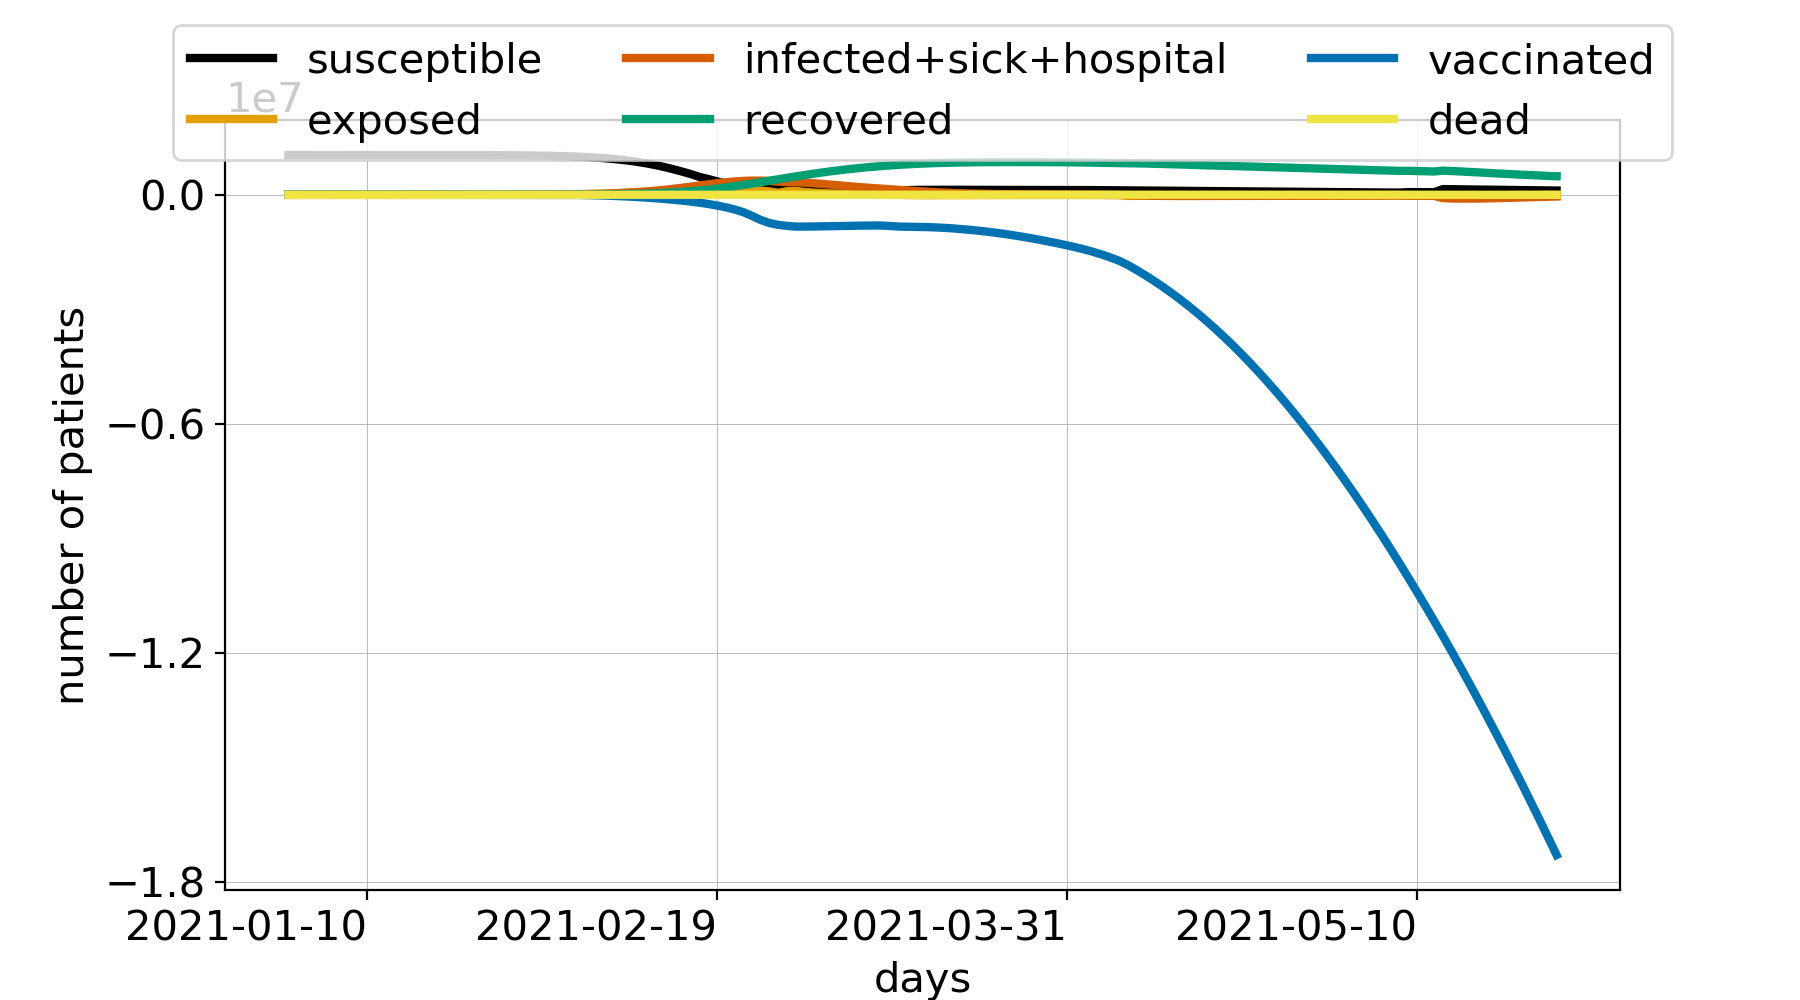

In [206]:
population_status(sim_dummy_spatial_model_vacc.mean(dim='place'))

# Scenarios

In [102]:
start_sim = '2020-09-01'
end_sim = '2021-07-01'
warmup = 0
n_samples = 5#100
n_draws_per_sample = 1000
effectivity = 0.9

In [103]:
Re_1feb = 0.958*1.4
# current estimation of UK prevalence between 20 and 40% => take 30%
current_UK = 0.3
# 5-6 days incubation
incubation_period = 5
n_periods = 30/incubation_period

In [104]:
# How much on January 1? (30 days ago)
portion_new_strain_introduced = current_UK/(Re_1feb**n_periods) #0.001
injection_day = (pd.Timestamp('2021-01-01') - pd.Timestamp(start_sim))/pd.Timedelta('1D')

## Run and save all scenarios

In [130]:
scenario_settings = pd.DataFrame({
    'Scenario_name':['S1a','S1b','S1c','S2a','S2b','S2c','S3a','S3b','S3c','S4a','S4b','S4c',
                     'S5a','S5b','S5c','S6a','S6b','S6c','S7a','S7b','S7c','S8a','S8b','S8c',
                     'SNV1a','SNV1b','SNV1c'],
    'scenario':(3*['1']+3*['2']+3*['3']+3*['4'])*2+3*['1'],
    'effectivity':12*[0.9]+12*[0.7]+3*[0.9],
    'K':9*[1.3,1.5,1.7],
    'vacc_fun':24*[vacc_strategy]+3*[None]})

In [134]:
scenario_settings = scenario_settings.set_index('Scenario_name')

In [151]:
n_samples = 2

In [162]:
pd.Timestamp(start_sim) +pd.Timedelta('173D')

Timestamp('2021-02-21 00:00:00')

In [196]:
scen='S3a'
scenario = scenario_settings.loc[scen,'scenario']
effectivity = scenario_settings.loc[scen,'effectivity']
K = scenario_settings.loc[scen,'K']
vacc_fun = scenario_settings.loc[scen,'vacc_fun']

scenario_model = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_fun)
scenario_model.parameters.update({'K':K})

In [199]:
n_samples=3

In [200]:
i = 0

while True:
    print(i)
    out = scenario_model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)
    if np.isnan(out['H_in']).any():
        break
    i += 1

0
1imulating draw 3/3
2imulating draw 3/3
3imulating draw 3/3
4imulating draw 3/3
5imulating draw 3/3
6imulating draw 3/3
7imulating draw 3/3
8imulating draw 3/3
9imulating draw 3/3
10mulating draw 3/3
11mulating draw 3/3
12mulating draw 3/3
13mulating draw 3/3
14mulating draw 3/3
15mulating draw 3/3
16mulating draw 3/3
17mulating draw 3/3
18mulating draw 3/3
19mulating draw 3/3
20mulating draw 3/3
21mulating draw 3/3
22mulating draw 3/3
23mulating draw 3/3
24mulating draw 3/3
25mulating draw 3/3
26mulating draw 3/3
27mulating draw 3/3
28mulating draw 3/3
29mulating draw 3/3
30mulating draw 3/3
31mulating draw 3/3
32mulating draw 3/3
33mulating draw 3/3
34mulating draw 3/3
35mulating draw 3/3
36mulating draw 3/3
37mulating draw 3/3
38mulating draw 3/3
39mulating draw 3/3
40mulating draw 3/3
41mulating draw 3/3
42mulating draw 3/3
43mulating draw 3/3
44mulating draw 3/3
45mulating draw 3/3
46mulating draw 3/3
47mulating draw 3/3
48mulating draw 3/3
49mulating draw 3/3
50mulating draw 3/

KeyboardInterrupt: 

In [182]:
results = pd.DataFrame()
for scen in scenario_settings.index:
    scenario = scenario_settings.loc[scen,'scenario']
    effectivity = scenario_settings.loc[scen,'effectivity']
    K = scenario_settings.loc[scen,'K']
    vacc_fun = scenario_settings.loc[scen,'vacc_fun']

    scenario_model = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                             injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                             Nc_fun=report7_policy_function, N_vacc_fun=vacc_fun)
    scenario_model.parameters.update({'K':K})
    out = scenario_model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

    H_in_binom = sample_from_binomial(out, 'H_in', n_draws_per_sample, n_samples)
    H_tot_binom = sample_from_binomial(out, 'H_tot', n_draws_per_sample, n_samples)
    time = out["time"].values
    
    results['Date'] =  time
    results[scen+'_incidences_mean'] = np.mean(H_in_binom, axis=1)
    results[scen+'_incidences_median'] = np.median(H_in_binom, axis=1)
    results[scen+'_incidences_LL'] = np.quantile(H_in_binom, q = LL, axis = 1)
    results[scen+'_incidences_UL'] = np.quantile(H_in_binom, q = UL, axis = 1)
    results[scen+'_load_mean'] = np.mean(H_tot_binom, axis=1)
    results[scen+'_load_median'] = np.median(H_tot_binom, axis=1)
    results[scen+'_load_LL'] = np.quantile(H_tot_binom, q = LL, axis = 1)
    results[scen+'_load_UL'] = np.quantile(H_tot_binom, q = UL, axis = 1)

## Scenarios S1 (current behaviour)

In [105]:
scenario = '1'

### S1a - K = 1.3

In [106]:
infectivity_gain_lower=1.3
infectivity_gain_upper=1.3

In [107]:
model_S1a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S1a = model_S1a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [113]:
model_S1a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
model_S1a.parameters.update({'K':1.3})
out_S1a_test = model_S1a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [71]:
S1a_H_in_binom = sample_from_binomial(out_S1a, 'H_in', n_draws_per_sample, n_samples)
S1a_H_tot_binom = sample_from_binomial(out_S1a, 'H_tot', n_draws_per_sample, n_samples)
S1a_time = out_S1a["time"].values
S1a_alpha = out_S1a['alpha'].mean(dim="Nc").values

### S1b - K = 1.5

In [72]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K


In [73]:
model_S1b = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S1b = model_S1b.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [74]:
S1b_H_in_binom = sample_from_binomial(out_S1b, 'H_in', n_draws_per_sample, n_samples)
S1b_H_tot_binom = sample_from_binomial(out_S1b, 'H_tot', n_draws_per_sample, n_samples)
S1b_time = out_S1b["time"].values
S1b_alpha = out_S1b['alpha'].mean(dim="Nc").values

### S1c - K = 1.7

In [72]:
K=1.7
infectivity_gain_lower=K
infectivity_gain_upper=K


In [73]:
model_S1c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S1c = model_S1c.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [74]:
S1c_H_in_binom = sample_from_binomial(out_S1c, 'H_in', n_draws_per_sample, n_samples)
S1c_H_tot_binom = sample_from_binomial(out_S1c, 'H_tot', n_draws_per_sample, n_samples)
S1c_time = out_S1c["time"].values
S1c_alpha = out_S1c['alpha'].mean(dim="Nc").values

## Scenarios S2 (september behaviour March 1)

In [75]:
scenario = '2'

### S2a - K = 1.3

In [76]:
K=1.3
infectivity_gain_lower=K
infectivity_gain_upper=K

In [79]:
model_S2a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S2a = model_S2a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [80]:
S2a_H_in_binom = sample_from_binomial(out_S2a, 'H_in', n_draws_per_sample, n_samples)
S2a_H_tot_binom = sample_from_binomial(out_S2a, 'H_tot', n_draws_per_sample, n_samples)
S2a_time = out_S2a["time"].values
S2a_alpha = out_S2a['alpha'].mean(dim="Nc").values


### S2b - K = 1.5

In [81]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [82]:
model_S2b = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S2b = model_S2b.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [83]:
S2b_H_in_binom = sample_from_binomial(out_S2b, 'H_in', n_draws_per_sample, n_samples)
S2b_H_tot_binom = sample_from_binomial(out_S2b, 'H_tot', n_draws_per_sample, n_samples)
S2b_time = out_S2b["time"].values
S2b_alpha = out_S2b['alpha'].mean(dim="Nc").values

### S2c - K = 1.7

In [72]:
K=1.7
infectivity_gain_lower=K
infectivity_gain_upper=K


In [73]:
model_S2c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S2c = model_S2c.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [74]:
S2c_H_in_binom = sample_from_binomial(out_S2c, 'H_in', n_draws_per_sample, n_samples)
S2c_H_tot_binom = sample_from_binomial(out_S2c, 'H_tot', n_draws_per_sample, n_samples)
S2c_time = out_S2c["time"].values
S2c_alpha = out_S2c['alpha'].mean(dim="Nc").values

## Scenario S3 (September behaviour April 1)

In [84]:
scenario = '3'

### S3a - K = 1.3

In [85]:
K=1.3
infectivity_gain_lower=K
infectivity_gain_upper=K

In [86]:
model_S3a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S3a = model_S3a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [87]:
S3a_H_in_binom = sample_from_binomial(out_S3a, 'H_in', n_draws_per_sample, n_samples)
S3a_H_tot_binom = sample_from_binomial(out_S3a, 'H_tot', n_draws_per_sample, n_samples)
S3a_time = out_S3a["time"].values
S3a_alpha = out_S3a['alpha'].mean(dim="Nc").values


### S3b - K = 1.5

In [88]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [89]:
model_S3b = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S3b = model_S3b.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [90]:
S3b_H_in_binom = sample_from_binomial(out_S3b, 'H_in', n_draws_per_sample, n_samples)
S3b_H_tot_binom = sample_from_binomial(out_S3b, 'H_tot', n_draws_per_sample, n_samples)
S3b_time = out_S3b["time"].values
S3b_alpha = out_S3b['alpha'].mean(dim="Nc").values

### S3c - K = 1.7

In [72]:
K=1.7
infectivity_gain_lower=K
infectivity_gain_upper=K


In [73]:
model_S3c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S3c = model_S3c.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [74]:
S3c_H_in_binom = sample_from_binomial(out_S3c, 'H_in', n_draws_per_sample, n_samples)
S3c_H_tot_binom = sample_from_binomial(out_S3c, 'H_tot', n_draws_per_sample, n_samples)
S3c_time = out_S3c["time"].values
S3c_alpha = out_S3c['alpha'].mean(dim="Nc").values

## Scenario S4 (September behaviour April 1)

In [84]:
scenario = '4'

### S4a - K = 1.3

In [85]:
K=1.3
infectivity_gain_lower=K
infectivity_gain_upper=K

In [86]:
model_S4a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S4a = model_S4a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [87]:
S4a_H_in_binom = sample_from_binomial(out_S4a, 'H_in', n_draws_per_sample, n_samples)
S4a_H_tot_binom = sample_from_binomial(out_S4a, 'H_tot', n_draws_per_sample, n_samples)
S4a_time = out_S4a["time"].values
S4a_alpha = out_S4a['alpha'].mean(dim="Nc").values


### S4b - K = 1.5

In [88]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [89]:
model_S4b = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S4b = model_S4b.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [90]:
S4b_H_in_binom = sample_from_binomial(out_S4b, 'H_in', n_draws_per_sample, n_samples)
S4b_H_tot_binom = sample_from_binomial(out_S4b, 'H_tot', n_draws_per_sample, n_samples)
S4b_time = out_S4b["time"].values
S4b_alpha = out_S4b['alpha'].mean(dim="Nc").values

### S4c - K = 1.7

In [72]:
K=1.7
infectivity_gain_lower=K
infectivity_gain_upper=K


In [73]:
model_S4c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S4c = model_S4c.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [74]:
S4c_H_in_binom = sample_from_binomial(out_S4c, 'H_in', n_draws_per_sample, n_samples)
S4c_H_tot_binom = sample_from_binomial(out_S4c, 'H_tot', n_draws_per_sample, n_samples)
S4c_time = out_S4c["time"].values
S4c_alpha = out_S4c['alpha'].mean(dim="Nc").values

## Scenarios SNV1 (vaccination effect)

### S3a (S2b without vaccination)

In [91]:
scenario = '2a'

In [92]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [93]:
model_S3a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S3a = model_S3a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [94]:
S3a_H_in_binom = sample_from_binomial(out_S3a, 'H_in', n_draws_per_sample, n_samples)
S3a_H_tot_binom = sample_from_binomial(out_S3a, 'H_tot', n_draws_per_sample, n_samples)
S3a_time = out_S3a["time"].values
S3a_alpha = out_S3a['alpha'].mean(dim="Nc").values


### S4a (S1b without vaccination)

In [95]:
scenario = '1'

In [96]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [97]:
model_S4a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S4a = model_S4a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [98]:
S4a_H_in_binom = sample_from_binomial(out_S4a, 'H_in', n_draws_per_sample, n_samples)
S4a_H_tot_binom = sample_from_binomial(out_S4a, 'H_tot', n_draws_per_sample, n_samples)
S4a_time = out_S4a["time"].values
S4a_alpha = out_S4a['alpha'].mean(dim="Nc").values


# Visualise

## S1 and S2

In [191]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax2, ax3) = plt.subplots(3,sharex=True,figsize=(10,15))
legend_pos = (0.5, 1.35)
legend_col = 2

label1 = 'current behaviour - +30%'
label2 = 'current behaviour - +50%'
label3 = 'SB March 1 - +30%'
label4 = 'SB March 1 - +50%'
label5 = 'SB May 1 - +50% '

# Incidence
plot_band_binom(ax1, S1a_time, S1a_H_in_binom, 'green', label=label1)
plot_band_binom(ax1, S1b_time, S1b_H_in_binom, 'blue', label=label2)
plot_band_binom(ax1, S2a_time, S2a_H_in_binom, 'orange', label=label3)
plot_band_binom(ax1, S2b_time, S2b_H_in_binom, 'red', label=label4)
plot_band_binom(ax1, S5b_time, S5b_H_in_binom, 'lightblue', label=label5)

ax1.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
plot_band_binom(ax2, S1a_time, S1a_H_tot_binom, 'green', label=label1)
plot_band_binom(ax2, S1b_time, S1b_H_tot_binom, 'blue', label=label2)
plot_band_binom(ax2, S2a_time, S2a_H_tot_binom, 'orange', label=label3)
plot_band_binom(ax2, S2b_time, S2b_H_tot_binom, 'red', label=label4)
plot_band_binom(ax2, S5b_time, S5b_H_tot_binom, 'lightblue', label=label5)


ax2.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_tot'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
plot_band_binom(ax3, S1a_time, S1a_alpha*100, 'green', label=label1, axis=0)
plot_band_binom(ax3, S1b_time, S1b_alpha*100, 'blue', label=label2, axis=0)
plot_band_binom(ax3, S2a_time, S2a_alpha*100, 'orange', label=label3, axis=0)
plot_band_binom(ax3, S2b_time, S2b_alpha*100, 'red', label=label4, axis=0)
plot_band_binom(ax3, S5b_time, S5b_alpha*100, 'lightblue', label=label5, axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
ax2.set_title('Total patients in hospital')
ax2.set_ylabel('$H_{tot}$ (-)')
ax2.set_xlim('2020-09-01',end_sim)
ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_S1a, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'Scenarios'+'.jpg', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>

ConversionError: Failed to convert value(s) to axis units: '2020-09-01'

In [ ]:
get_date_of_exceeding_alpha(out_S1b, ['Nc', 'draws'], 0.45)

In [ ]:
check_overtake_duration(out_S1a, ['Nc', 'draws'])

## Vaccination effect

<IPython.core.display.Javascript object>


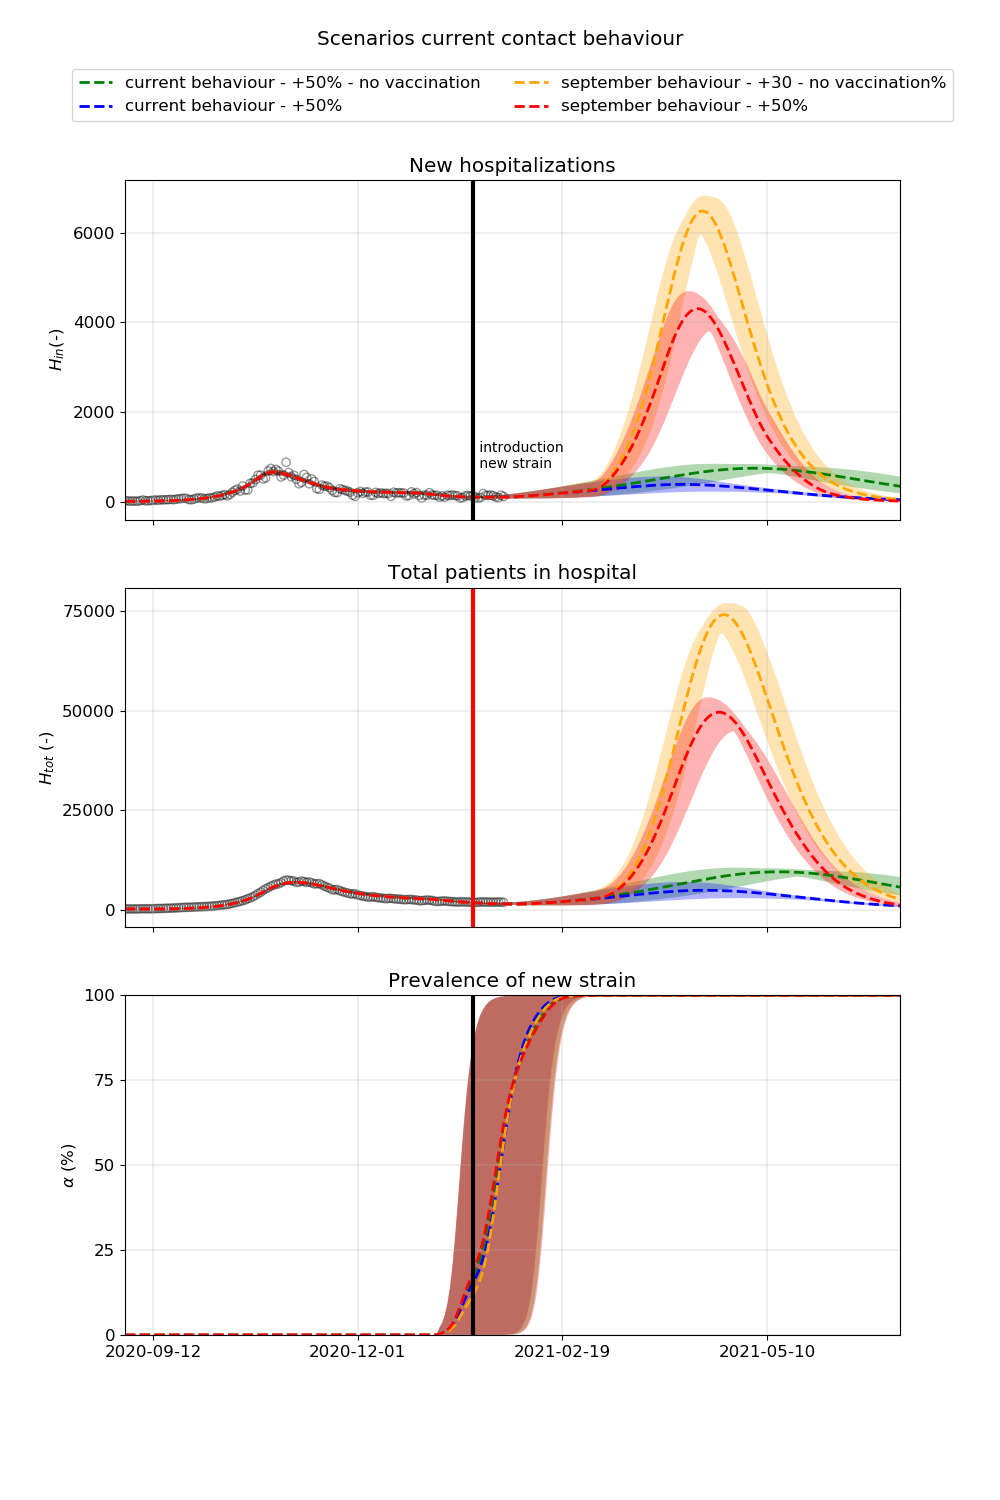

In [100]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax2, ax3) = plt.subplots(3,sharex=True,figsize=(10,15))
legend_pos = (0.5, 1.35)
legend_col = 2

label1 = 'current behaviour - +50% - no vaccination'
label2 = 'current behaviour - +50%'
label3 = 'september behaviour - +30 - no vaccination%'
label4 = 'september behaviour - +50%'

# Incidence
plot_band_binom(ax1, S4a_time, S4a_H_in_binom, 'green', label=label1)
plot_band_binom(ax1, S1b_time, S1b_H_in_binom, 'blue', label=label2)
plot_band_binom(ax1, S3a_time, S3a_H_in_binom, 'orange', label=label3)
plot_band_binom(ax1, S2b_time, S2b_H_in_binom, 'red', label=label4)

ax1.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
plot_band_binom(ax2, S4a_time, S4a_H_tot_binom, 'green', label=label1)
plot_band_binom(ax2, S1b_time, S1b_H_tot_binom, 'blue', label=label2)
plot_band_binom(ax2, S3a_time, S3a_H_tot_binom, 'orange', label=label3)
plot_band_binom(ax2, S2b_time, S2b_H_tot_binom, 'red', label=label4)

ax2.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_tot'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
plot_band_binom(ax3, S4a_time, S4a_alpha*100, 'green', label=label1, axis=0)
plot_band_binom(ax3, S1b_time, S1b_alpha*100, 'blue', label=label2, axis=0)
plot_band_binom(ax3, S3a_time, S3a_alpha*100, 'orange', label=label3, axis=0)
plot_band_binom(ax3, S2b_time, S2b_alpha*100, 'red', label=label4, axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
ax2.set_title('Total patients in hospital')
ax2.set_ylabel('$H_{tot}$ (-)')
ax2.set_xlim('2020-09-01',end_sim)
ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
# date_exceed = get_date_of_exceeding_alpha(out_S4a, ['Nc', 'draws'], 0.25)
# ax3.axvline(x=date_exceed, color='gray')
# ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
#          fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
fig.savefig(fig_path+'Scenarios_vaccination'+'.jpg', dpi=400, bbox_inches='tight')

# Alternative scenarios A1

In [ ]:
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15' # Initiate new strain on 15 Jan
end_sim2 = '2021-05-01'
warmup = 0
n_samples = 5
n_draws_per_sample = 50
effectivity = 0.9
portion_new_strain_introduced = 0.001
scenario = '1'

## A1a - vacc - old strain

In [ ]:
model_A1a = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A1a = model_A1a.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A1a_H_in_binom = sample_from_binomial(out_A1a, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A1a_time = out_A1a["time"].values
A1a_alpha = out_A1a['alpha'].mean(dim="Nc").values

## A1b - no vacc - new strain

In [ ]:
model_A1b = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A1b = model_A1b.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A1b.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A1b_part2 = vaccin_model(initial_states_2, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A1b_part2 = model_A1b_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A1b_H_in_binom = sample_from_binomial(out_A1b, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A1b_H_in_binom = sample_from_binomial(out_A1b_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, A1b_H_in_binom)

In [ ]:
# A1b_H_tot_binom = sample_from_binomial(out_A1b, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# A1b_H_tot_binom = sample_from_binomial(out_A1b_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, A1b_H_tot_binom)

In [ ]:
A1b_time = out_A1b["time"].values
A1b_alpha = out_A1b['alpha'].mean(dim="Nc").values
A1b_time = np.append(A1b_time, out_A1b_part2['time'].values)
A1b_alpha = np.append(A1b_alpha,out_A1b_part2['alpha'].mean(dim="Nc").values,axis=1)

## A1c - vaccination - old strain

In [ ]:
model_A1c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A1c = model_A1c.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A1c_H_in_binom = sample_from_binomial(out_A1c, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A1c_time = out_A1c["time"].values
A1c_alpha = out_A1c['alpha'].mean(dim="Nc").values

## A1d - vaccination - new strain

In [ ]:
model_A1d = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A1d = model_A1d.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A1d.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A1d_part2 = vaccin_model(initial_states_2, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A1d_part2 = model_A1d_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
model_A1d_part2.parameters['beta']

In [ ]:
A1d_H_in_binom = sample_from_binomial(out_A1d, 'H_in', n_draws_per_sample, n_samples)
A1d_H_in_binom = sample_from_binomial(out_A1d_part2, 'H_in', n_draws_per_sample, n_samples, A1d_H_in_binom)

In [ ]:
# A1d_H_tot_binom = sample_from_binomial(out_A1d, 'H_tot', n_draws_per_sample, n_samples)
# A1d_H_tot_binom = sample_from_binomial(out_A1d_part2, 'H_tot', n_draws_per_sample, n_samples, A1d_H_tot_binom)

In [ ]:
A1d_time = out_A1d["time"].values
A1d_alpha = out_A1d['alpha'].mean(dim="Nc").values
A1d_time = np.append(A1d_time, out_A1d_part2['time'].values)
A1d_alpha = np.append(A1d_alpha,out_A1d_part2['alpha'].mean(dim="Nc").values,axis=1)

## Visualise

In [ ]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax3) = plt.subplots(2,sharex=True,figsize=(10,10))
legend_pos = (0.5, 1.25)
legend_col = 2

# Incidence
plot_band_binom(ax1, A1a_time, A1a_H_in_binom, 'green', label='no new strain')
plot_band_binom(ax1, A1b_time, A1b_H_in_binom, 'blue', label='new strain on 15/1')
plot_band_binom(ax1, A1c_time, A1c_H_in_binom, 'orange', label='no new strain - vacc')
plot_band_binom(ax1, A1d_time, A1d_H_in_binom, 'red', label='new strain on 15/1 - vacc')

ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
# plot_band_binom(ax2, A1b_time, A1b_H_tot_binom, 'blue', label='H_in')
# ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
# ax3.plot(A1a_time,np.mean(A1a_alpha,axis=0)*100,'--', color='green', label='no new strain')
# ax3.plot(A1b_time,np.mean(A1b_alpha,axis=0)*100,'--', color='blue', label='new strain on 15/1')
# ax3.fill_between(A1b_time,np.quantile(A1b_alpha,UL,axis=0)*100, np.quantile(A1b_alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
plot_band_binom(ax3, A1a_time, A1a_alpha*100, 'green', label='no new strain', axis=0)
plot_band_binom(ax3, A1b_time, A1b_alpha*100, 'blue', label='new strain on 15/1', axis=0)
plot_band_binom(ax3, A1c_time, A1c_alpha*100, 'orange', label='no new strain - vacc', axis=0)
plot_band_binom(ax3, A1d_time, A1d_alpha*100, 'red', label='new strain on 15/1 - vacc', axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
# ax2.set_title('Total patients in hospital')
# ax2.set_ylabel('$H_{tot}$ (-)')
# ax2.set_xlim('2020-09-01',end_sim2)
# ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
# ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_A1b_part2, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'A1'+'.jpg', dpi=400, bbox_inches='tight')

In [ ]:
date_exceed = get_date_of_exceeding_alpha(out_A1b_part2, ['Nc', 'draws'], 0.25)

In [ ]:
check_overtake_duration(out_A1b_part2, ['Nc', 'draws'])

# Alternative scenarios A2

In [ ]:
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15' # Initiate new strain on 15 Jan
end_sim2 = '2021-07-01'
warmup = 0
n_samples = 5
n_draws_per_sample = 50
effectivity = 0.9
portion_new_strain_introduced = 0.001
scenario = '2a'

## A2a - no vacc - old strain

In [ ]:
model_A2a = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A2a = model_A2a.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2a_H_in_binom = sample_from_binomial(out_A2a, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2a_time = out_A2a["time"].values
A2a_alpha = out_A2a['alpha'].mean(dim="Nc").values

## A2b - no vacc - new strain

In [ ]:
model_A2b = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A2b = model_A2b.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A2b.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A2b_part2 = vaccin_model(initial_states_2, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A2b_part2 = model_A2b_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2b_H_in_binom = sample_from_binomial(out_A2b, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2b_H_in_binom = sample_from_binomial(out_A2b_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, A2b_H_in_binom)

In [ ]:
# A2b_H_tot_binom = sample_from_binomial(out_A2b, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# A2b_H_tot_binom = sample_from_binomial(out_A2b_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, A2b_H_tot_binom)

In [ ]:
A2b_time = out_A2b["time"].values
A2b_alpha = out_A2b['alpha'].mean(dim="Nc").values
A2b_time = np.append(A2b_time, out_A2b_part2['time'].values)
A2b_alpha = np.append(A2b_alpha,out_A2b_part2['alpha'].mean(dim="Nc").values,axis=1)

## A2c - vaccination - old strain

In [ ]:
model_A2c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A2c = model_A2c.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2c_H_in_binom = sample_from_binomial(out_A2c, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2c_time = out_A2c["time"].values
A2c_alpha = out_A2c['alpha'].mean(dim="Nc").values

## A2d - vaccination - new strain

In [ ]:
model_A2d = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A2d = model_A2d.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A2d.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A2d_part2 = vaccin_model(initial_states_2, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A2d_part2 = model_A2d_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2d_H_in_binom = sample_from_binomial(out_A2d, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2d_H_in_binom = sample_from_binomial(out_A2d_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, A2d_H_in_binom)

In [ ]:
# A2d_H_tot_binom = sample_from_binomial(out_A2d, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# A2d_H_tot_binom = sample_from_binomial(out_A2d_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, A2d_H_tot_binom)

In [ ]:
A2d_time = out_A2d["time"].values
A2d_alpha = out_A2d['alpha'].mean(dim="Nc").values
A2d_time = np.append(A2d_time, out_A2d_part2['time'].values)
A2d_alpha = np.append(A2d_alpha,out_A2d_part2['alpha'].mean(dim="Nc").values,axis=1)

## Visualise

In [ ]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax3) = plt.subplots(2,sharex=True,figsize=(10,10))
legend_pos = (0.5, 1.25)
legend_col = 2

# Incidence
plot_band_binom(ax1, A2a_time, A2a_H_in_binom, 'green', label='no new strain')
plot_band_binom(ax1, A2b_time, A2b_H_in_binom, 'blue', label='new strain on 15/1')
plot_band_binom(ax1, A2c_time, A2c_H_in_binom, 'orange', label='no new strain - vacc')
plot_band_binom(ax1, A2d_time, A2d_H_in_binom, 'red', label='new strain on 15/1 - vacc')

ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
# plot_band_binom(ax2, A2b_time, A2b_H_tot_binom, 'blue', label='H_in')
# ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
# ax3.plot(A2a_time,np.mean(A2a_alpha,axis=0)*100,'--', color='green', label='no new strain')
# ax3.plot(A2b_time,np.mean(A2b_alpha,axis=0)*100,'--', color='blue', label='new strain on 15/1')
# ax3.fill_between(A2b_time,np.quantile(A2b_alpha,UL,axis=0)*100, np.quantile(A2b_alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
plot_band_binom(ax3, A2a_time, A2a_alpha*100, 'green', label='no new strain', axis=0)
plot_band_binom(ax3, A2b_time, A2b_alpha*100, 'blue', label='new strain on 15/1', axis=0)
plot_band_binom(ax3, A2c_time, A2c_alpha*100, 'orange', label='no new strain - vacc', axis=0)
plot_band_binom(ax3, A2d_time, A2d_alpha*100, 'red', label='new strain on 15/1 - vacc', axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
# ax2.set_title('Total patients in hospital')
# ax2.set_ylabel('$H_{tot}$ (-)')
# ax2.set_xlim('2020-09-01',end_sim2)
# ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
# ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_A2b_part2, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios release on  March 1')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'A2'+'.jpg', dpi=400, bbox_inches='tight')

# Save data

In [101]:
results = pd.DataFrame()
results['Date'] =  out_S1a['time']
for x in ['S1a', 'S1b', 'S2a', 'S2b', 'S3a', 'S4a', 'S5a', 'S5b']:
    for var in ['H_in', 'H_tot']:
        binom = eval(x+'_'+var+'_binom')
        if var == 'H_in':
            results[x+'_incidences_mean'] = np.mean(binom, axis=1)
            results[x+'_incidences_median'] = np.median(binom, axis=1)
            results[x+'_incidences_LL'] = np.quantile(binom, q = LL, axis = 1)
            results[x+'_incidences_UL'] = np.quantile(binom, q = UL, axis = 1)
        if var == 'H_tot':
            results[x+'_load_mean'] = np.mean(binom, axis=1)
            results[x+'_load_median'] = np.median(binom, axis=1)
            results[x+'_load_LL'] = np.quantile(binom, q = LL, axis = 1)
            results[x+'_load_UL'] = np.quantile(binom, q = UL, axis = 1)
            
results.to_csv('../../results/predictions/national/restore_v7.0/UGent_restore_v7.csv')

# Plot saved data

In [ ]:
S_results_H_in = pd.read_csv('../../results/vaccinations/national/S_results_H_in.csv', parse_dates=['time'])

In [ ]:
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')


In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')

# plot_band(ax3, y_model_S4a, 'H_in', 'C0', '0% at start')
# plot_band(ax3, y_model_S4b, 'H_in', 'C1', '10% at start')
# plot_band(ax3, y_model_S4c, 'H_in', 'C2', '30% at start')
# plot_band(ax3, y_model_S4d, 'H_in', 'C3', '50% at start')

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
# plot_band(ax4, y_model_S1, 'H_in', 'gray', 'no vaccination')
# plot_band(ax4, y_model_S5a, 'H_in', 'C0', '0% at start')
# plot_band(ax4, y_model_S5b, 'H_in', 'C1', '10% at start')
# plot_band(ax4, y_model_S5c, 'H_in', 'C2', '30% at start')
# plot_band(ax4, y_model_S5d, 'H_in', 'C3', '50% at start')

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')


ax3.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax3.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')
